In [1]:
# import packages
import h5py
import numpy as np
import torch
from mirtorch.linear import NuSense, Diag, Diff3dgram, NuSenseGram
from mirtorch.alg.cg import CG

# select device
if torch.cuda.is_available():
    print('CUDA is available')
    device0 = torch.device('cuda:2')
else:
    print('CUDA is not available')
    device0 = torch.device('cpu')
    
torch.no_grad()

CUDA is available


In [2]:
# load in the data
fname = '/home/djfrey/data/acr_lps_sos_test/sos_data/data.h5'

with h5py.File(fname, 'r') as h5_file:
    kdata = h5_file['kdata/real'][:] + 1j * h5_file['kdata/imag'][:] # kspace data
    ktraj = h5_file['ktraj'][:] # kspace trajectory (1/cm)
    fov = h5_file['seq_args/fov'][0][0] # fov (cm)
    N = int(h5_file['seq_args/N'][0][0]) # 3D matrix size
    nprj = int(h5_file['seq_args/nprj'][0][0]) # number of projections
    nint = int(h5_file['seq_args/nint'][0][0]) # number of interleaves
ncoil = kdata.shape[0] # number of coils
ndat = kdata.shape[3] # number of samples per projection

In [3]:
# create trajectory (in radians) and data matrix
b = torch.tensor(kdata).reshape(ncoil, 1, nint*nprj*ndat)
om = 2*torch.pi * fov/N * torch.tensor(ktraj.transpose(2,0,1,3)).reshape(3, nint*nprj*ndat)

In [ ]:
# loop through coils and calculate AHb
A = NuSense(torch.ones(1,1,N,N,N).to(b.dtype).to(device0), om.to(device0))
AHb = torch.zeros(ncoil,1,N,N,N).to(b.dtype)
for c in range(ncoil):
    bc = b[c:(c+1),:,:].to(device0)
    AHb[c,0] = (A.H * bc).to('cpu').squeeze(0).squeeze(0)

# offload the GPU memory
del A, bc
torch.cuda.empty_cache()

In [ ]:
# create the forward model with batch dimension over coils
AHA = NuSenseGram(torch.ones(ncoil,1,N,N,N).to(b.dtype).to(device0), om.to(device0))

# add L2 roughness penalty
lam = 0.01
THT = Diff3dgram(AHA.size_in)
AHA_tikh = AHA + lam*THT

# create the solver
solv = CG(AHA, max_iter=30)

# offload the GPU memory
del AHA, THT, AHA_tikh
torch.cuda.empty_cache()

In [ ]:
# solve with CG
x0 = torch.zeros(ncoil,1,N,N,N).to(b.dtype)
x = solv.run(x0.to(device0), AHb.to(device0))

OutOfMemoryError: CUDA out of memory. Tried to allocate 1008.00 MiB. GPU 2 has a total capacity of 10.57 GiB of which 900.12 MiB is free. Including non-PyTorch memory, this process has 9.68 GiB memory in use. Of the allocated memory 9.48 GiB is allocated by PyTorch, and 26.00 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

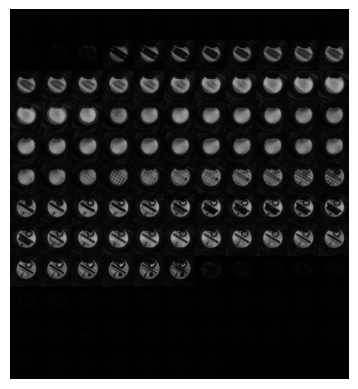

In [ ]:
from vis3d import im
x_rms = x.abs().pow(2).sum(0).sqrt().cpu().numpy()
im(x_rms[0])
im(x_rms[0],type='mid3')